In [ ]:
!pip install scipy
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn

## Поиск выбросов (outlier detection) и аномалий в данных

Выброс - такой объект в признаке, который отличается от остальных (очень странные значения, не похожие на другие). Но в тоже время, является **реально сущесвутющим** объектом.

Так как, он является корректным значением (не пустым, не опечаткой), то влечет иной способ обработки. С прошлыми случаями мы поступали так - заменяли на среднее, медиану, КК, расстояния, регрессию, итп.

Поступают с ними очень жестко - как только вы нашли выброс, то **безжалостно удаляем**

Зачем нужно искать и удалять выбросы:
- если задачей является предсказывание, то удаление выброса то как правило увеличивает точность.
- получаем типичные данные
- большинство статистических характеристик очень чувствительны к выбросам (если посчитаем зарплату сотрудников компании Рога и Копыта, то получим вполне себе среднюю зарплату, но если в выборку добавим топ менеджет гугла, то средняя зарплата перестанет быть адекватной)

Несколько слов о выбросах:
- математического определения выброса **не существует!**, кроме того, каждый алгоритм/человек/что-то еще имеет свой способ определения что же такое этот выброс. Исходя из этого, сложно провести конкретно четкую границу между нормой и аномалией
- "жетский" способ удаления выбросов будет удалять и часть типичных (нормальных) объектов
- "мягкий " способ удаления выбросов будет оставлять и выбросы

То есть, идеального и строго определенного подхода к выбросам - **не существует!**


Как искать:
- смысловая нагрузка признака. Мы знаем, что типичный рост человека где-то в дапозоне $ [140,200](см) $, тогда как 250см тоже существует, но является выбросом
- методы основанные на анализе одного признака (каждый признак анализируется отдельно)
- методы основанные на анализе сразу нескольких признаков

Вывод:
- наличие выбросов ухудшает качество ML моделей
- сложно формально определить, что такое выброс
- нетипичные значения в генеральной совокупности - есть выброс


### Простейшие идеи поиска выбросов

$X = (x_1, x_2, ..., x_n)$

$\bar X$ - среднее

$n$ - размер выборки

$S_x$ - отклонение

Идея - найти все объекты, которые слишком далеко от среднего (медианы, другой метрики):
1. удалить те объекты, у которых $|x_1 - \bar x|$ далеко
2. удалить те объекты, у которых ${|x_1 - \bar x|} \over S_x$ далеко
3. критерий Шовене
4. без использования среднего и отклонения


#### Пример алгоритма идеи 2

1. a - подозреваемый на выброс
2. уберем a из выборки и вычислим среднее и отклонение без него
3. если выборка является симметричной (см lec03), то x является выбросом, если не принадлежит $(\bar X - 3S_x, \bar X + 3S_x)$
4. если не симметрична, то то x является выбросом, если не принадлежит $(\bar X - 5S_x, \bar X + 5S_x)$

#### Критерий Шовене (Chauvenet)

Более продвинутый способ поиска выброса - критерий шовене

Суть:
значение $x_i$ будет выбросом, если выполнено неравенство $erfc({|x_i - \bar x| \over S_x}) < {1 \over 2n} $ 

[erfc](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA) - дополнительная функция ошибок. C возврастанием аргумента функция стримится к нулю. То есть, если подставить в неравенство слишком больше число, то значение будет выбросом.

функцию можно использовать многократно. 

In [19]:
from scipy.special import erfc
import numpy as np
import scipy.stats as st

arr = np.array([3,5,8,15,100,32,126,384])

def chauvenet(y: np.array, mean=None, stdv=None) -> np.array:
    # based on https://github.com/msproteomicstools/msproteomicstools/blob/master/msproteomicstoolslib/math/chauvenet.py
    '''
        Returns: np.array[bool]. if false, then outlier
    '''
    if mean is None:
        mean = y.mean()    # Mean of incoming array y
    if stdv is None:
        stdv = y.std()      # Its standard deviation

    abs_deviation = np.abs(y - mean) / stdv
    d = erfc(abs_deviation)
    # Calculate the maximum absolute deviation that is still acceptable according to Chauvenet's criterion
    threshold = 1 / (2 * y.size - 1)

    # Determine which data points are outliers
    is_outlier = d > threshold

    # Return the indices of the outliers
    return is_outlier

train = np.array([1,2,3,4,5,6,7,8, 100 ])


mean = train.mean()
stdv = train.std()

def iterate(sample: np.array, repeat: bool = True) -> np.array:
    test_result = chauvenet(sample, mean, stdv)
    repeat = np.any(test_result == False)
    
    print('sample: ', sample)
    print('test_result: ', test_result)
    print('-----')
    
    if repeat:
        return iterate(sample[test_result], repeat)
    
    return sample
    
print(iterate(sample=train))

sample:  [  1   2   3   4   5   6   7   8 100]
test_result:  [ True  True  True  True  True  True  True  True False]
-----
sample:  [1 2 3 4 5 6 7 8]
test_result:  [ True  True  True  True  True  True  True  True]
-----
[1 2 3 4 5 6 7 8]


#### Поиск без среднего и отклонения

Использование среднего и отклонения приводит к проблемам (которые рассматривались ранее), так как эти метрики сильно чувствительны к выбросам.

Возникает идея, использовать методы, основанные на более устойчивых метриках

##### Квартили

$Q_{25}$ - такое число, что 25% выборки меньше 

$Q_{50}$ - Такое число, что 50% выборки меньше

$Q_{75}$ - такое число, что 75% выборки меньше 

Как считаем?
1) Соортируем и ищем медиану - получаем $Q_{50}$
2) Делим выборку на 2 части, left - меньше медианы, right - больше медианы
3) Ищем медиану внутри этих выборок, получаем $Q_{25}$ из left, $Q_{75}$ из right

Как использовать для поиска аномалий?

Фактически, 50% выборки лежит в интервале $[Q_{25}, Q_{75}]$, тогда элементы, которые сильно далеки от $Q_{25}$, $Q_{75}$ этого интервала, считаем выбросами.

Правило: Если элемент не попадает в интервал $(Q_{25} - 1.5*(Q_{75} - Q_{25}), Q_{75} + 1.5*(Q_{75} - Q_{25}))$, то элемент есть выброс

P.S. на этом и основан boxplot

### Методы основанные на нескольких признаках

Недостатки методов, основанные на одном признаке

1) Представим выборку $(1,100,1,100,1,100, 30, 30, 30, 100,1, 100, 30, 50)$, 50 очевидно выброс, но ни один из методов анализа одного признака не сможет его отловить

2) Аномалии могут характеризоваться не только экстримальными значениями одного признака, но и комбинацией нескольких признаков (визульно можно посмотреть при помощи scatter). Например, рост 180см и вес 30кг

Какие идеи могут помочь?
1) метрические методы (расстояние от объекта, до его ближайших соседей очень большое)
2) геометрические методы
3) кластеризация (обучение без учителя). Например, если объект попадает в слишком маленький кластер, то вероятно это выброс
4) модели машинного обучения, различные вариациии decision trees, некоторые SVM
5) использовать предсказание признака по другим признакам, объекты для которых предсказание предсказание сильно разнится, можно объявить выбросом. **Но скорее всего, такой алгоритм не даст нормального результата, нужно быть с этим аккуратнее. Такое можно использовать, когда мы четко понимаем, что это зависимые величины**

[*дополнительно почитать](http://data4.ru/anomalydetection)

In [20]:
import numpy as np

def to_pairs(arr1, arr2):
    return np.vstack((arr1, arr2)).T

def standard_scale(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Normalize the data
    X_norm = (X - mean) / std
    
    return X_norm

<AxesSubplot:>

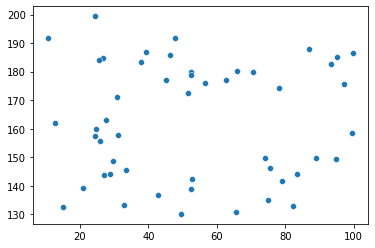

In [21]:
import seaborn as sns
import numpy as np

%matplotlib inline

np.random.seed(54)

weight = np.random.uniform(low=10, high=100, size=(50,))
# sam
height = np.random.uniform(low=130, high=200, size=(50,))

sns.scatterplot(x=weight, y=height) # видим, , что точки выше 190 и с маленьким весом вероятно являются выбросами

Для примера рассмотрим метод [кластеризации основанный на плотности](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), более детально методы обучения без учителя будет изучать далее.

У данного метода есть 2 обязтаельных параметра:
- EPS: Максимальное расстояние между двумя точками, при котором точка считается соседним с другой. Это самый важный параметр DBSCAN, который следует правильно выбрать для вашего набора данных и функции расстояния. (про то, как выбирать EPS поговорим в следующих лекциях)
- min_samples: минимальное количетсов точек в кластере


dots labels:  [0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 3, 9, 10, 11, 12, 13, 9, 14, 6, 13, 9, 2, 15, 15, 3, 16, 3, 15, 17, 3, 18, 19, 15, 11, 11, 16, 10, 20, 10, 3, 21, 22, 10, 15, 13, 3, 11, 23, 23, 24]


<AxesSubplot:>

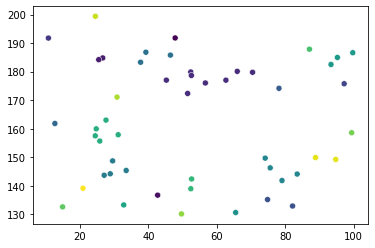

In [22]:
from sklearn.cluster import DBSCAN

X = to_pairs(weight, height) # превращаем вес, рост в пары
X_norm = standard_scale(X) # используем стандартизацию

# ВАЖНО! на обучение отдаем нормированные данные!
clustering = DBSCAN(eps=0.3, min_samples=1).fit(X_norm) # обучаем модель, сейчас EPS была выбрана случайным образом

x_labels = clustering.labels_ # получаем отношение точек к кластеру
print('dots labels: ', list(x_labels))
sns.scatterplot(x=weight, y=height, c=clustering.labels_)


Points to leave = False: [False, False, False, True, False, False, False, False, True, False, True, True, True, True, False, True, True, False, False, True, True, False, True, True, True, False, True, True, False, True, False, False, True, True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, False, False]

 Как видим из результата, выборка стала более стабильной 


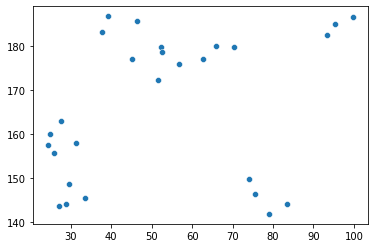

In [23]:
from collections import Counter
# Далее говорим, что выбросами являются те точки, у которых расстояние до других точек слишком больше (мы это видим, по количеству точек в кластерах)
labels_counter = Counter(x_labels) 

# далее дропаем те, у которых только меньше двух точек в кластере

filter_dots = np.array([labels_counter[label] > 2 for label in x_labels])

print('Points to leave = False:', list(filter_dots))

X_filtered = X[filter_dots]
height_filtered =  X_filtered[:, 1]
weight_filttered = X_filtered[:, 0]

sns.scatterplot(x=weight_filttered, y=height_filtered)
print('\n', 'Как видим из результата, выборка стала более стабильной ')

## Гипотезы и статистическая значимость

Немного забегая вперед про нормальное распределение, рассмотрим для примера набор данных с хорошим нормальным распределением - набор данных с ирисами :-)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import load_iris
iris = load_iris()
#функция numpy.c_ выполняет конкатенацию массивов вдоль второй оси - т.е. присоединяет столбцы
#и переименуем эти ужасные названия признаков
irDf = pd.DataFrame( data = np.c_[iris["data"],iris["target"]], columns = ["sepl","sepw","petl","petw","target"])
irDf.head()


,sepl,sepw,petl,petw,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Посмотрим на различия средних. Видно, что они отличаются. Данный пример уже подразумевает разделение классов объектов, но зачастую такие различия могут быть найдены в произвольном наборе данных: средние значения одного свойства, сгруппированные по какому-либо признаку (например, размер зарплат сотрудников определенной должности, разбитый по группам "пол сотрудника"). 


In [25]:
irDf.groupby(["target"])[["sepl","sepw","petl","petw"]].mean()

,sepl,sepw,petl,petw
target,,,,
0.0,5.006,3.428,1.462,0.246
1.0,5.936,2.770,4.260,1.326
2.0,6.588,2.974,5.552,2.026


Возникает вопрос, насколько корректно обобщать найденные различия. Являются ли данные различия характерными только для данной выборки или они характерны и для **генеральной совокупности**?

Для этого выполняется проверка **статистических гипотез**.

Не прибегая к строгим формулировкам, для начального понимания под гипотезой будем понимать статистически значимое различие между средними выборок (**независимых**). 

Каковы критерии, что считать достаточным различием между выборками?


### t-критерий (t-test). Независимый двухвыборочный тест Стьюдента


Данный критерий основывается на распределении Стьюдента путем вычисления t-статистики Стьюдента для двух назависымых выборок по формуле (на самом деле, это формула Уэлча):

$ t = \frac{ \bar{X_1} - \bar{X_2} }{ \sqrt{ \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} } }, $

где 
* $\bar{X_1}, \bar{X_2}$ - средние обеих выборок,
* $s_1, s_2$ - стандартные отклонения выборок, а $s_1^2, s_2^2$ - их дисперсии
* $n_i$ - размер соответствующей выборки


Как видно, значение критерия прямо зависит от разницы средних значений выборок, и чем оно больше (по аобсолютной величине) с учетом средних дисперсий, разумеется, тем **ВЕРОЯТНЕЕ** различие между этими выборками.

А как выразить эту вероятность?

Рассмотрим распределение Стьюдента

[]

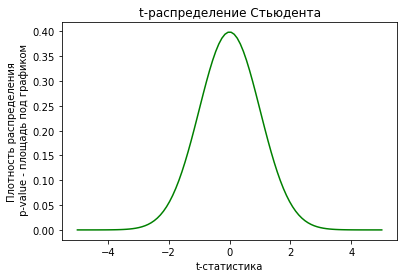

In [44]:
x = np.linspace(-5,5,100)
t_distr = stats.t(1E10, 0)

plt.plot(x, t_distr.pdf(x), "g-")
plt.ylabel("Плотность распределения\n p-value - площадь под графиком")
plt.xlabel("t-статистика")
plt.title("t-распределение Стьюдента")
plt.plot()

Из графика распределения видно, что значение **p-value** (площадь под графиком плотности) тем больше, чем ближе значение t-статистики к нулю, т.е., в нашем случае, чем меньше различие между выборками.

Таким образом, значение **p-value** выражает вероятность **подтверждения НУЛЕВОЙ ГИПОТЕЗЫ** $H_0$, состоящей в том, что нет никаких статистических различий в указанных выборках, а различия их выборочных средних характерны исключительно для данных выборок, а не для генеральной совокупности.

А если p-value будет очень мало? Т.е. вероятность подтверждения нулевой гипотезы мала, а значит...

Есть место для **АЛЬТЕРНАТИВНОЙ ГИПОТЕЗЫ** $H_1$, которая, как правило, в случае с выборочными средними состоит в обратном утверждении, что их различия **не случайны** и характерны для генеральной совокупности.

Однако, это не означает что она точно верна. Обычно утверждается **отклонение нулевой гипотезы и принятие альтернативной с вероятностю ошибиться не более $\alpha$**,

где $\alpha$ - принимаемый **уровень значимости**, порог вероятности который берется обычно в виде значений: {0.1, 0.05, 0.01}

Следует также учитывать, односторонний тест или двухсторонний. 

Односторонний тест подразумевает, что одна выборка заведомо больше или меньше другой (см. формулу t-критерия). 

В случае двухстороннего теста, необходимо учитывать, что площадь с каждой стороны уменьшится в 2 раза. В этом случае часто прибегают к уменьшению порога в 2 раза, т.е. $\alpha / 2$ (0.025 вместо 0.05 и т.д.)

<table>
    <tr>
        <td><img src="src/Two tailed result.png"></td>
        <td><img src="src/One tailed t-test result lower tail.png"></td>
        <td><img src="src/One tailed t-test result upper tail.png"></td>
    </tr>
</table>


 Итак, возвращаемся к задаче проверки гипотезы различия параметра "длина чашелистика" у разных типов ирисов.
 Посмотрим визуально гистограммы:

[]

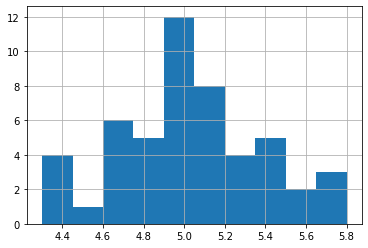

In [39]:
irDf[irDf.target == 0].sepl.hist()
plt.plot()

Каой существует формальный метод определения нормальности распределения?

### Тест Шапиро-Уилка нормальности распределения

Результат теста интерпретируется с помощью значения p-value способом аналогично рассмотренном выше:

In [34]:
print( stats.shapiro(irDf[irDf.target == 0].sepl) )
print( stats.shapiro(irDf[irDf.target == 1].sepl) )
print( stats.shapiro(irDf[irDf.target == 2].sepl) )

ShapiroResult(statistic=0.9776989221572876, pvalue=0.4595281183719635)
ShapiroResult(statistic=0.9778355956077576, pvalue=0.46473264694213867)
ShapiroResult(statistic=0.9711798429489136, pvalue=0.25832483172416687)


Как можно видеть, для критерия значимости $\alpha = 0.05$, выборки во всех трех группах распределены нормально, следовательно можно применять тест Стьюдента с нормировкой дисперсий



### Двухвыборочный независимый тест Стьюдента

Функция **ttest_ind( X,Y, equal_var = True)** принимает выборки X, Y, а параметр *equal_var* указывает на то, что у этих выборок одинаковая дисперсия. Если *equal_var = False*, то выполняется тест Уэлча

Сущекствует методика, согласно которой обычный тест Стьюдента можно запускать, если соотношение дисперсий (наибольшей к наименьшей) выборок не превышает 4: 

$\frac {s_1^2}{s_2^2} \le 4 , s_1 \gt s_2$

или

np.max( np.var(group1), np.var(group2) ) / np.min( np.var(group1), np.var(group2) <= 4

In [60]:
print("0 - 1", stats.ttest_ind(irDf[irDf.target == 0].sepl, irDf[irDf.target == 1].sepl, equal_var = False ) )
print("0 - 2", stats.ttest_ind(irDf[irDf.target == 0].sepl, irDf[irDf.target == 2].sepl, equal_var = False ) )
print("1 - 2", stats.ttest_ind(irDf[irDf.target == 1].sepl, irDf[irDf.target == 2].sepl, equal_var = False ) )


0 - 1 Ttest_indResult(statistic=-10.52098626754911, pvalue=3.746742613983842e-17)
0 - 2 Ttest_indResult(statistic=-15.386195820079404, pvalue=3.9668672709859296e-25)
1 - 2 Ttest_indResult(statistic=-5.629165259719801, pvalue=1.8661443873771216e-07)


Как можно видеть, для пар выборок нулевая гипотеза об отсутствии различий между группами отклоняется, т.е. с вероятностью ошибиться менее 1% можно сказать, что все эти группы различны

### Paired t-test. Тест Стьюдента для связных выборок (влияние воздействия)

Одним из условий корректного использования рассмотренного выше t-теста являлось независимость выборок, т.е. в ней должны присутствовать разные объекты.

Данный тест предназначен для проверки различия групп зависимых объектов. Например, после некоторого воздействия.

Данный тест позволяет оценить наличие воздействия на группу объектов.

Нулевая гипотеза та же: различие средних в представленных выборках случайно.

In [57]:

sampleSize = 50
#скорость (время) бега на 100 м. (сек) до приема препарата
runSpeed = np.random.normal( loc = 14.0, scale = 0.6, size = sampleSize )
#время бега на 100 м. после приема препарата
afterMed = runSpeed + np.random.normal( loc = 2.0, scale = 0.3, size = sampleSize )

runDf = pd.DataFrame({"runTimeBefore": runSpeed, "runTimeAfter": afterMed, "runTimeDelta": afterMed - runSpeed})
#weight_df = pd.DataFrame({"weight_before":before, "weight_after":after, "weight_change":after-before})

runDf.describe()
#weight_df.describe()             

,runTimeBefore,runTimeAfter,runTimeDelta
count,50.000000,50.000000,50.000000
mean,14.061001,15.977459,1.916458
std,0.593494,0.726644,0.317171
min,12.540648,14.211894,0.961915
25%,13.728540,15.555775,1.709976
50%,14.068843,16.038053,1.932589
75%,14.481492,16.390805,2.162226
max,15.251827,17.417563,2.426432


In [58]:
stats.ttest_rel(runSpeed, afterMed)

Ttest_relResult(statistic=-42.72592843773883, pvalue=1.9241206140566817e-40)

Как можно видеть, гипотезу что препарат не влияет на снижение скорости можно отклонить с вероятностью ошибиться менее, чем на 1%

### U-критерий Манна — Уитни

t-тест Стьюдента использует средние арифметические значения, что приводит к его неустойчивости при наличии аномальных выбросов и формы распределения, отличающейся от нормальной.

В такой ситуации прибегают к использованию U-критерия Манна-Уитни. 
Он относится к непараметрическим критериям, и работает даже с порядковыми (категориальными) значениями

In [2]:
import zipfile
zf = zipfile.ZipFile("../lec02/lec02_data.zip", "r")
#print(zf.namelist())
with zf.open("student-mat.csv") as f:
    studMat = pd.read_csv(f)

studMat.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Посмотрим связь между употреблением алкоголя в викенд (Walc) и употреблением в будни (Dalc) по уровням: сравним группы максимального и минимального потребления в викенд

In [73]:
studMat.groupby(["Walc"])["Dalc"].agg(pd.Series.mode)

Walc
1    1
2    1
3    1
4    2
5    5
Name: Dalc, dtype: int64

In [74]:
studMat.groupby(["Walc"])["Dalc"].mean()

Walc
1    1.006623
2    1.270588
3    1.600000
4    2.039216
5    3.321429
Name: Dalc, dtype: float64

Проанализировав данные таблицы, можно отметить, что высокий уровень употребления алкоголя в выходные свидетельствует о высоком употреблении и в будни. 

Проверим эту гипотезу с помощью теста Манна-Уитни


In [75]:
stats.mannwhitneyu( studMat[studMat.Walc == 5].Dalc, studMat[studMat.Walc == 1].Dalc )

MannwhitneyuResult(statistic=306.5, pvalue=5.2812010507957215e-33)

Таким образом, тест  Манна-Уитни по порядковым значениям уровней потребляемого алкоголя показал, что с вероятностью ошибиться менее 1% можно принять гипотезу о том, что студенты, употребляющие большое кол-во алкоголя в выходные, также много употребляют и в рабочие дни.

### Тест хи-квадрат (Chi-Squared Test of Independence)

Непараметрический тест на выявление зависимости между двумя категориальными переменными.

Основывается на построении таблицы сопряженности (**contingency table**) и сравнении ожидаемых теоретических частот значений и фактических

Рассмотрим на примре связь между уровнем потребления алкоголя студентами в викенд и уровнем образования матери/отца

In [6]:
ctabMother = studMat[["Medu","Walc"]].copy()
ctabFather = studMat[["Fedu","Walc"]].copy()
ctabFather

,Fedu,Walc
0,4,1
1,1,1
2,1,3
3,2,1
4,3,2
...,...,...
390,2,5
391,1,4
392,1,3
393,2,4


In [14]:
stat, pval, dof, expect = stats.chi2_contingency(ctabMother)
print(f"stat: {stat}, p-value: {pval}")

stat: 241.09832010582014, p-value: 0.9999999998909024


Нулевую гипотезу о независимости показателя потребления алкоголя на выходных и уровня оьбразования матери не отклоняем - зависимости нет.

In [15]:
stat, pval, dof, expect = stats.chi2_contingency(ctabFather)
print(f"stat: {stat}, p-value: {pval}")

stat: 231.5347493838372, p-value: 0.9999999999957684


Нулевую гипотезу о независимости показателя потребления алкоголя на выходных и уровня образования отца не отклоняем - зависимости нет.

Выполним тест $\chi^2$ для определения независимости признаков уровня потребления алкоголя в выходные и будни


In [17]:
dailyAlc = studMat[["Dalc","Walc"]].copy()
stat, pval, dof, expect = stats.chi2_contingency(dailyAlc)
print(f"stat: {stat}, p-value: {pval}")

stat: 69.04720605088929, p-value: 1.0


Таким образом, сами параметры уровня употребления студентами алкоголя в выходные и будни (без группировки по максимальному уровню) являются независимыми

<hr>

Гипотеза - это предположение, которое делается на основе доступных данных, для того чтобы проверить ее на согласованность с фактическими данными или выявить возможные закономерности. Гипотеза обычно формулируется в виде утверждения о взаимосвязи между двумя или более переменными. Например, гипотеза может быть о том, что наличие специального диетического режима улучшает здоровье пациентов с определенным заболеванием.

Статистическая значимость - это вероятность того, что различия между двумя группами или результаты исследования случайны и не могут быть объяснены только случайными факторами. Таким образом, статистическая значимость указывает на то, что различия между группами или результаты исследования настолько большие, что они не могут быть объяснены случайностью и, следовательно, они имеют реальное значение. Оценка статистической значимости обычно выполняется при помощи статистических тестов, которые позволяют определить вероятность того, что различия между группами являются статистически значимыми.

Проверка гипотез используется для проверки обоснованности утверждения (нулевой гипотезы), сделанного в отношении совокупности с использованием выборочных данных. Альтернативная гипотеза — это та, в которую вы бы поверили, если бы нулевая гипотеза оказалась неверной.

Символьные обозначения:
- $H_0$ - (нулевая гипотеза) разница не является статистически значимой, т. е. наблюдаемые данные могут происходят из ожидаемого распределения.
- $H_1$ - (альтернативная гипотеза) разница является статистически значимой, т. е. наблюдаемые данные не могут происходят из ожидаемого распределения.

**Если по простому**

Значимость переменной будет доказана, если мы опровергнем $H_0$ и ~примем~ (на самом деле никогда не используем оборот, что гипотеза является принятой, более правильным подходом называть данные состояние - не опровергнем) альтернативную гипотезу $H_1$

*[Изучить более подробно](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html)

### P-value

P-value - это вероятность получить такие же или более экстремальные результаты, чем наблюдаемые в эксперименте, при условии, что нулевая гипотеза верна.

Нулевая гипотеза - это общепринятая теория или утверждение, которое мы пытаемся опровергнуть или подтвердить в ходе эксперимента.

Например, мы можем провести эксперимент, чтобы проверить, есть ли различия в среднем росте мужчин и женщин. Нулевая гипотеза в данном случае может звучать так: "Средний рост мужчин и женщин одинаковый".

P-value рассчитывается путем определения статистической значимости между двумя выборками. Это делается с помощью статистических методов, таких как t-тест, ANOVA, корреляция Пирсона и другие.

После того, как статистическая значимость рассчитана, P-value вычисляется путем определения, насколько вероятно, что мы получили наши наблюдаемые данные при условии, что нулевая гипотеза верна.

Например, если мы получили P-value $>=$ 0.05 , это означает, что при условии, что нулевая гипотеза верна, есть 5% вероятность получить такие же или более экстремальные результаты, чем наблюдаемые в эксперименте.

Чем меньше P-value, тем меньше вероятность получить такие же или более экстремальные результаты при условии, что нулевая гипотеза верна, и тем более убедительными будут наши данные для отвержения нулевой гипотезы. Обычно установлен порог P-value в 0.05 или 0.01, что означает, что если P-value меньше этого порога, мы можем считать результаты статистически значимыми и отвергнуть нулевую гипотезу.

<img src='https://imgs.xkcd.com/comics/p_values.png' />

**Если по простому**

Когда P-value ниже порога (обычно 0.05, но иногда берут и 0.01 - например в медицинских данных), то это значит, что различия значимы и нам стоит использовать этот признак для дальнейшего исследования данных.

Следующие методы рассматривают более глобальную и сложную тему **Feature Selection**, с которой более глубже мы познакомимся позже.

### Классификация статистических тестов

* материал взят с [https://agricolamz.github.io/](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html)

#### Классификация по количеству выборок

- Одновыборочные тесты (one-sample tests) - используются для проверки гипотезы о среднем значении выборки относительно известного значения или для сравнения выборочного среднего с теоретическим значением.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-509-1.png" width=400 />

- Двухвыборочные тесты (two-sample tests) - используются для сравнения средних значений двух независимых выборок, чтобы определить, являются ли они статистически значимо различными.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-510-1.png" width=400 />

- Многовыборочные тесты (multiple-sample tests) - используются для сравнения средних значений более чем двух независимых выборок.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-511-1.png" width=400 />

#### Классификация по направлению

- Односторонние тесты проверяют гипотезу только в одном направлении, то есть они определяют, являются ли данные больше или меньше определенного значения. Например, односторонний тест может проверять гипотезу о том, что новый лекарственный препарат лучше, чем старый.

- Двухсторонние тесты, наоборот, проверяют гипотезу в обоих направлениях, то есть они определяют, отличаются ли данные от определенного значения в любом направлении. Например, двухсторонний тест может проверять гипотезу о том, что средний вес людей в определенной группе отличается от некоторого значения.

#### Классификация по парным, непарным

- Парные тесты предназначены для анализа зависимых выборок, где одна и та же группа испытуемых измеряется дважды или более. Например, при исследовании влияния нового лекарства на пациентов, можно провести парный тест и сравнить результаты до и после лечения для каждого пациента.

- Непарные тесты, наоборот, предназначены для анализа независимых выборок, где каждый наблюдатель рассматривается только в одной группе. Например, можно провести непарный тест и сравнить среднюю продолжительность сна мужчин и женщин в выборке.

#### Классификация по параметрическим, непараметрическим

- Параметрические статистические гипотезы базируются на определенных предположениях о распределении данных в генеральной совокупности. Эти предположения обычно включают нормальность распределения и однородность дисперсии. Параметрические тесты могут быть более мощными, то есть более чувствительными к выявлению различий между группами, но они также более чувствительны к нарушениям предположений о распределении данных.

- Непараметрические статистические гипотезы не требуют предположений о распределении данных в генеральной совокупности. Эти тесты могут быть менее мощными, но они также более устойчивы к нарушениям предположений о распределении данных.

<table>
    <thead>
        <tr class="header">
            <th>распределение</th>
            <th>тип группы</th>
            <th align="center">количество групп</th>
            <th>тест</th>
        </tr>
    </thead>
    <tbody>
        <tr class="odd">
            <td>категориальные</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>биномиальный тест, χ²</td>
        </tr>
        <tr class="even">
            <td>категориальные</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>χ², тест Фишера, G-test (LL-score)</td>
        </tr>
        <tr class="odd">
            <td>категориальные</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>критерий Мак-Нимара</td>
        </tr>
        <tr class="even">
            <td>нормальное</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>одновыборочный t-test</td>
        </tr>
        <tr class="odd">
            <td>нормальное</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>t-test для независимых выборок</td>
        </tr>
        <tr class="even">
            <td>нормальное</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>парный t-test</td>
        </tr>
        <tr class="odd">
            <td>не нормальное</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>критерий Уилкоксона</td>
        </tr>
        <tr class="even">
            <td>не нормальное</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>критерий Манна-Уитни</td>
        </tr>
        <tr class="odd">
            <td>не нормальное</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>критерий Уилкоксона</td>
        </tr>
    </tbody>
</table>

## Статистические тесты

**важное замечение!!!**

перед применением тестов, необходимо нормировать данные